In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = 15 
batch_size = 16
num_epochs = 15

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'split_data/train/',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        'split_data/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_data/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the input shape
input_shape = (224, 224, 3)

# Define the model architecture
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Define the number of steps per epoch
train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size

# Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=val_steps)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)


Found 5536 images belonging to 15 classes.
Found 686 images belonging to 15 classes.
Found 706 images belonging to 15 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                           

In [4]:
import numpy as np
from sklearn.metrics import label_ranking_average_precision_score
from keras.utils import to_categorical

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# Get model predictions
y_pred = model.predict(test_generator)

# Calculate LWLRAP

y_true = to_categorical(test_generator.labels, num_classes=15)
lwlrAP = label_ranking_average_precision_score(y_true, y_pred)

# Calculate top-5 categorical accuracy
top_5_acc = 0
for i in range(len(test_generator)):
    batch = test_generator[i]
    x_batch, y_batch = batch[0], batch[1]
    y_pred_batch = model.predict(x_batch)
    top_5_acc += np.mean(np.any(np.argsort(y_pred_batch)[:,-5:] == np.argmax(y_batch, axis=1).reshape(-1,1), axis=1))
top_5_acc /= len(test_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('LWLRAP:', lwlrAP)
print('Top-5 categorical accuracy:', top_5_acc)

1/1 [==============================] - 0s 59ms/step
Test loss: 0.15326957404613495
Test accuracy: 0.7407932281494141
LWLRAP: 0.834300103421916
Top-5 categorical accuracy: 0.9583333333333334


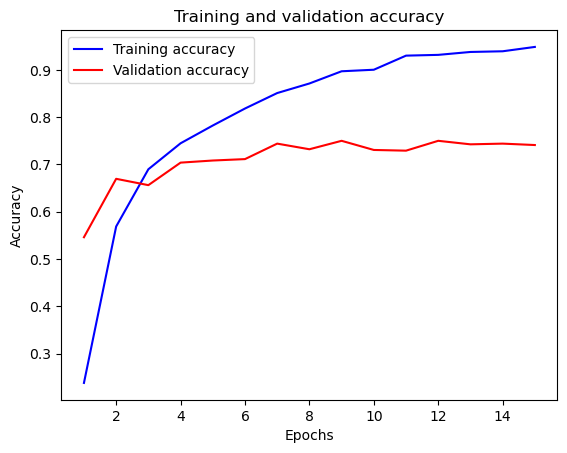

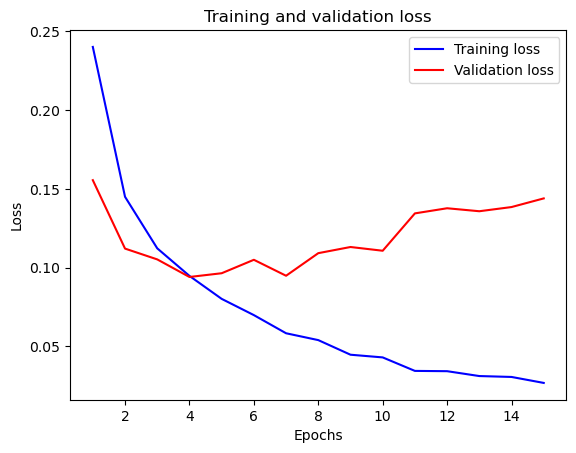

In [5]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



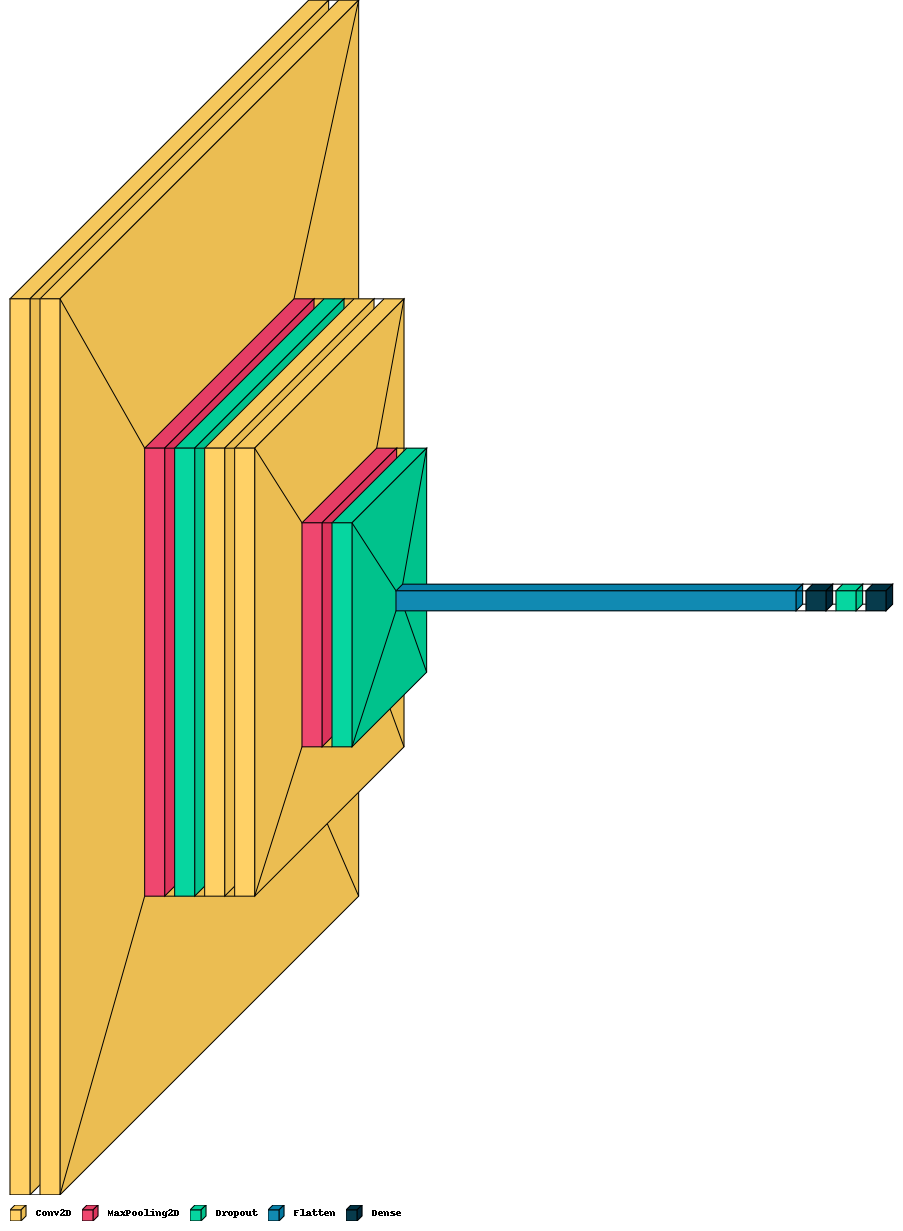

In [6]:
import visualkeras
from keras_visualizer import visualizer 

visualkeras.layered_view(model, legend=True) 